In [1]:
!pip install numpy==1.23.3 pandas matplotlib seaborn datetime sklearn tensorflow sktime

  Using cached numpy-1.23.3-cp310-cp310-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached sktime-0.13.4-py3-none-any.whl (7.0 MB)
  Using cached sktime-0.13.3-py3-none-any.whl (7.0 MB)
  Using cached sktime-0.13.2-py3-none-any.whl (6.9 MB)
  Using cached sktime-0.13.1-py3-none-any.whl (6.9 MB)
  Using cached sktime-0.13.0-py3-none-any.whl (6.8 MB)
  Using cached sktime-0.9.0.tar.gz (12.8 MB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      error: Multiple top-level packages discovered in a flat-layout: ['sktime', 'build_tools', 'extension_templates'].
      
      To avoid accidental inclusion of unwanted files or directories,
      setuptools will not proceed with this build.
      
      If you are trying to create a single distribution with multiple packages
      on purpose, you should not rely on automatic discovery.
      Instead, consider the f

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
style.use('ggplot')
import seaborn as sns
from datetime import datetime, timedelta
import random

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score

# classification metrics
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve, precision_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.utils import pad_sequences

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint


2022-11-29 22:24:23.443214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read data

## Read labels

In [3]:
labels = []
with open ("train_block_labels.txt", "r") as f:
    line = f.readlines()
    labels = list(map(int, line[0].split(' ')))

In [4]:
labels

[31, 35, 88, 44, 29, 24, 40, 50, 29]

In [5]:
labels_long = []
for i, label in enumerate(labels):
    labels_long += label * [i]
labels_long = np.array(labels_long)

In [6]:
len(labels_long)

370

In [7]:
print(labels_long)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


## Read training set and test set

In [8]:
groups = []
group = []
with open ("train.txt", "r") as f:
    for line in f.readlines():
        if line == '\n':
            groups.append(group[:])
            group = []
            continue
        group.append(line.split(' ')[:-1])

In [9]:
n = len(groups)
trains = []
for i in range(n):
    trains.append(pd.DataFrame(groups[i]).astype('float'))

In [10]:
len(trains)

370

In [11]:
# check null values
sum(trains[i].isna().sum().sum() for i in range(len(trains)))

0

In [12]:
groups = []
group = []
with open ("test.txt", "r") as f:
    for line in f.readlines():
        if line == '\n':
            groups.append(group[:])
            group = []
            continue
        group.append(line.split(' ')[:-1])
n = len(groups)
tests = []
for i in range(n):
    tests.append(pd.DataFrame(groups[i]).astype('float'))

In [13]:
len(tests)

270

In [14]:
# check null values
sum(tests[i].isna().sum().sum() for i in range(len(tests)))

0

# Exploratory Data Analysis

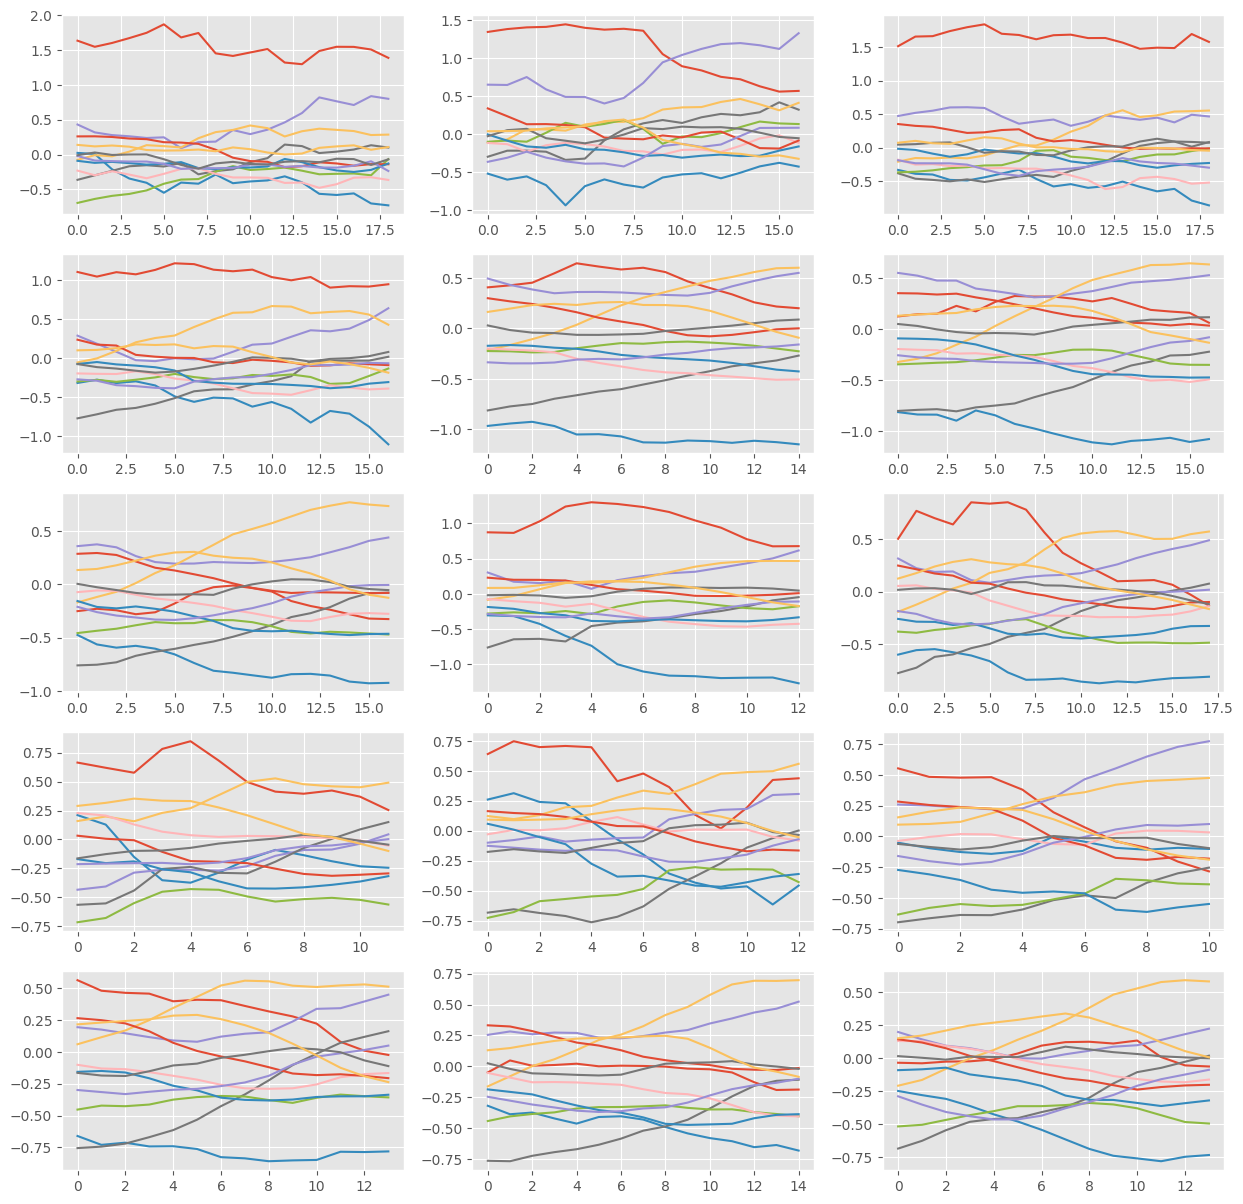

In [15]:
samples = 5
plt.subplots(samples, 3, figsize=(15, 3 * samples))
plots_x = [0] + [labels[i] for i in range(samples)]
for i in range(samples):
    for j in range(3):
        plt.subplot(samples, 3, 3 * i + 1 + j)
        plt.plot(trains[plots_x[i] + j])
        

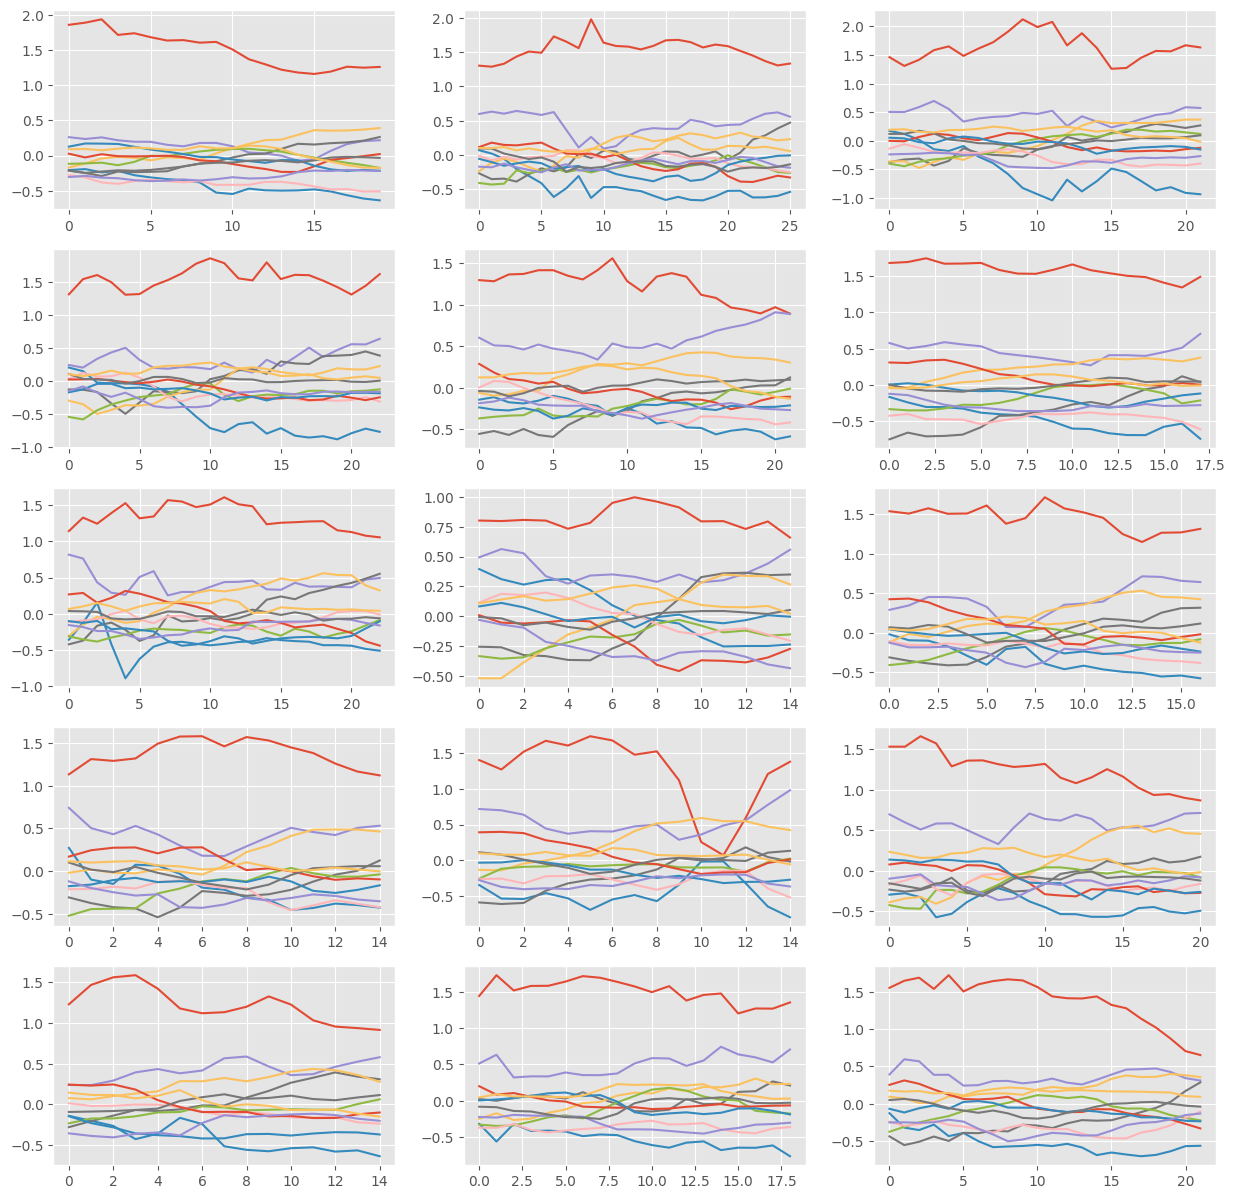

In [16]:
plt.subplots(5, 3, figsize=(15, 15))
for i in range(samples):
    for j in range(3):
        plt.subplot(samples, 3, 3 * i + 1 + j)
        plt.plot(tests[5*i+j])


In [17]:
### visualize the last person's histgram

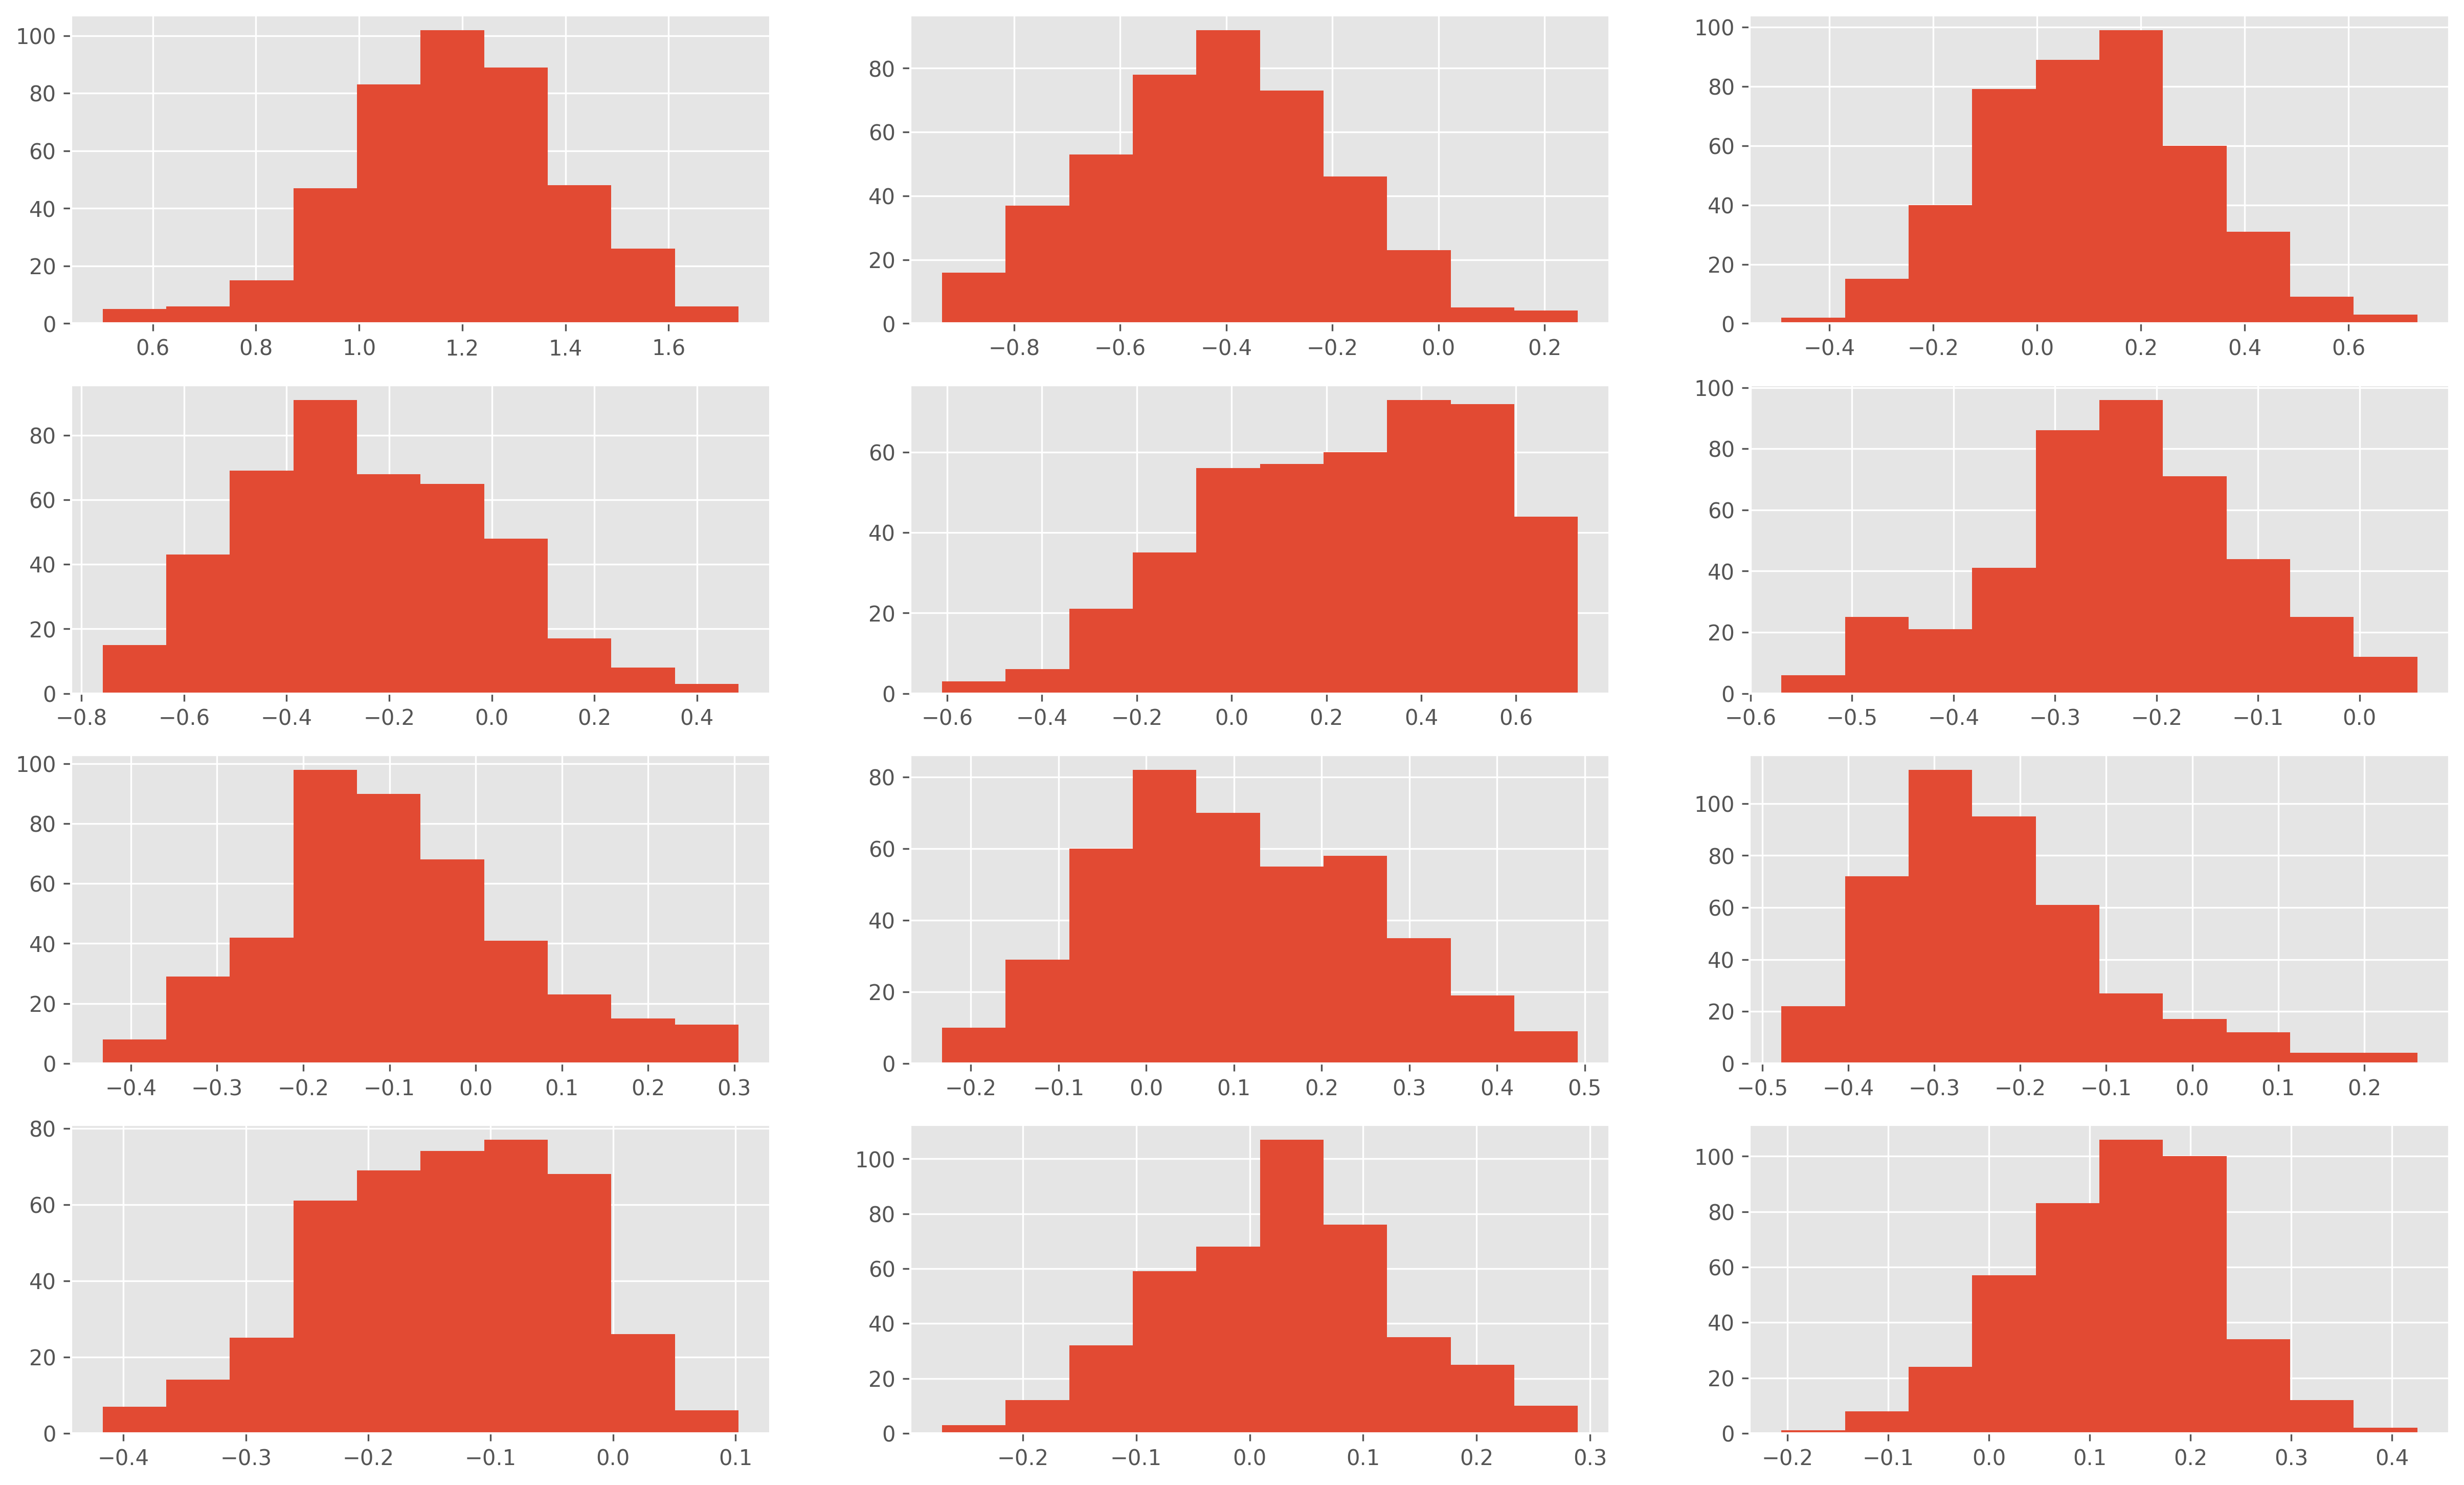

In [18]:
plt.subplots(4, 3, figsize=(20, 12), dpi=300)
datas = [[] for _ in range(12)]
for x in range(4):
    for y in range(3):
        for i in range(sum(labels[:-1]), sum(labels)):
            datas[x*3+y] += list(trains[i][x*3+y].values)
            
for x in range(4):
    for y in range(3):
        plt.subplot(4, 3, 3 * x + 1 + y)
        plt.hist(datas[3*x+y])

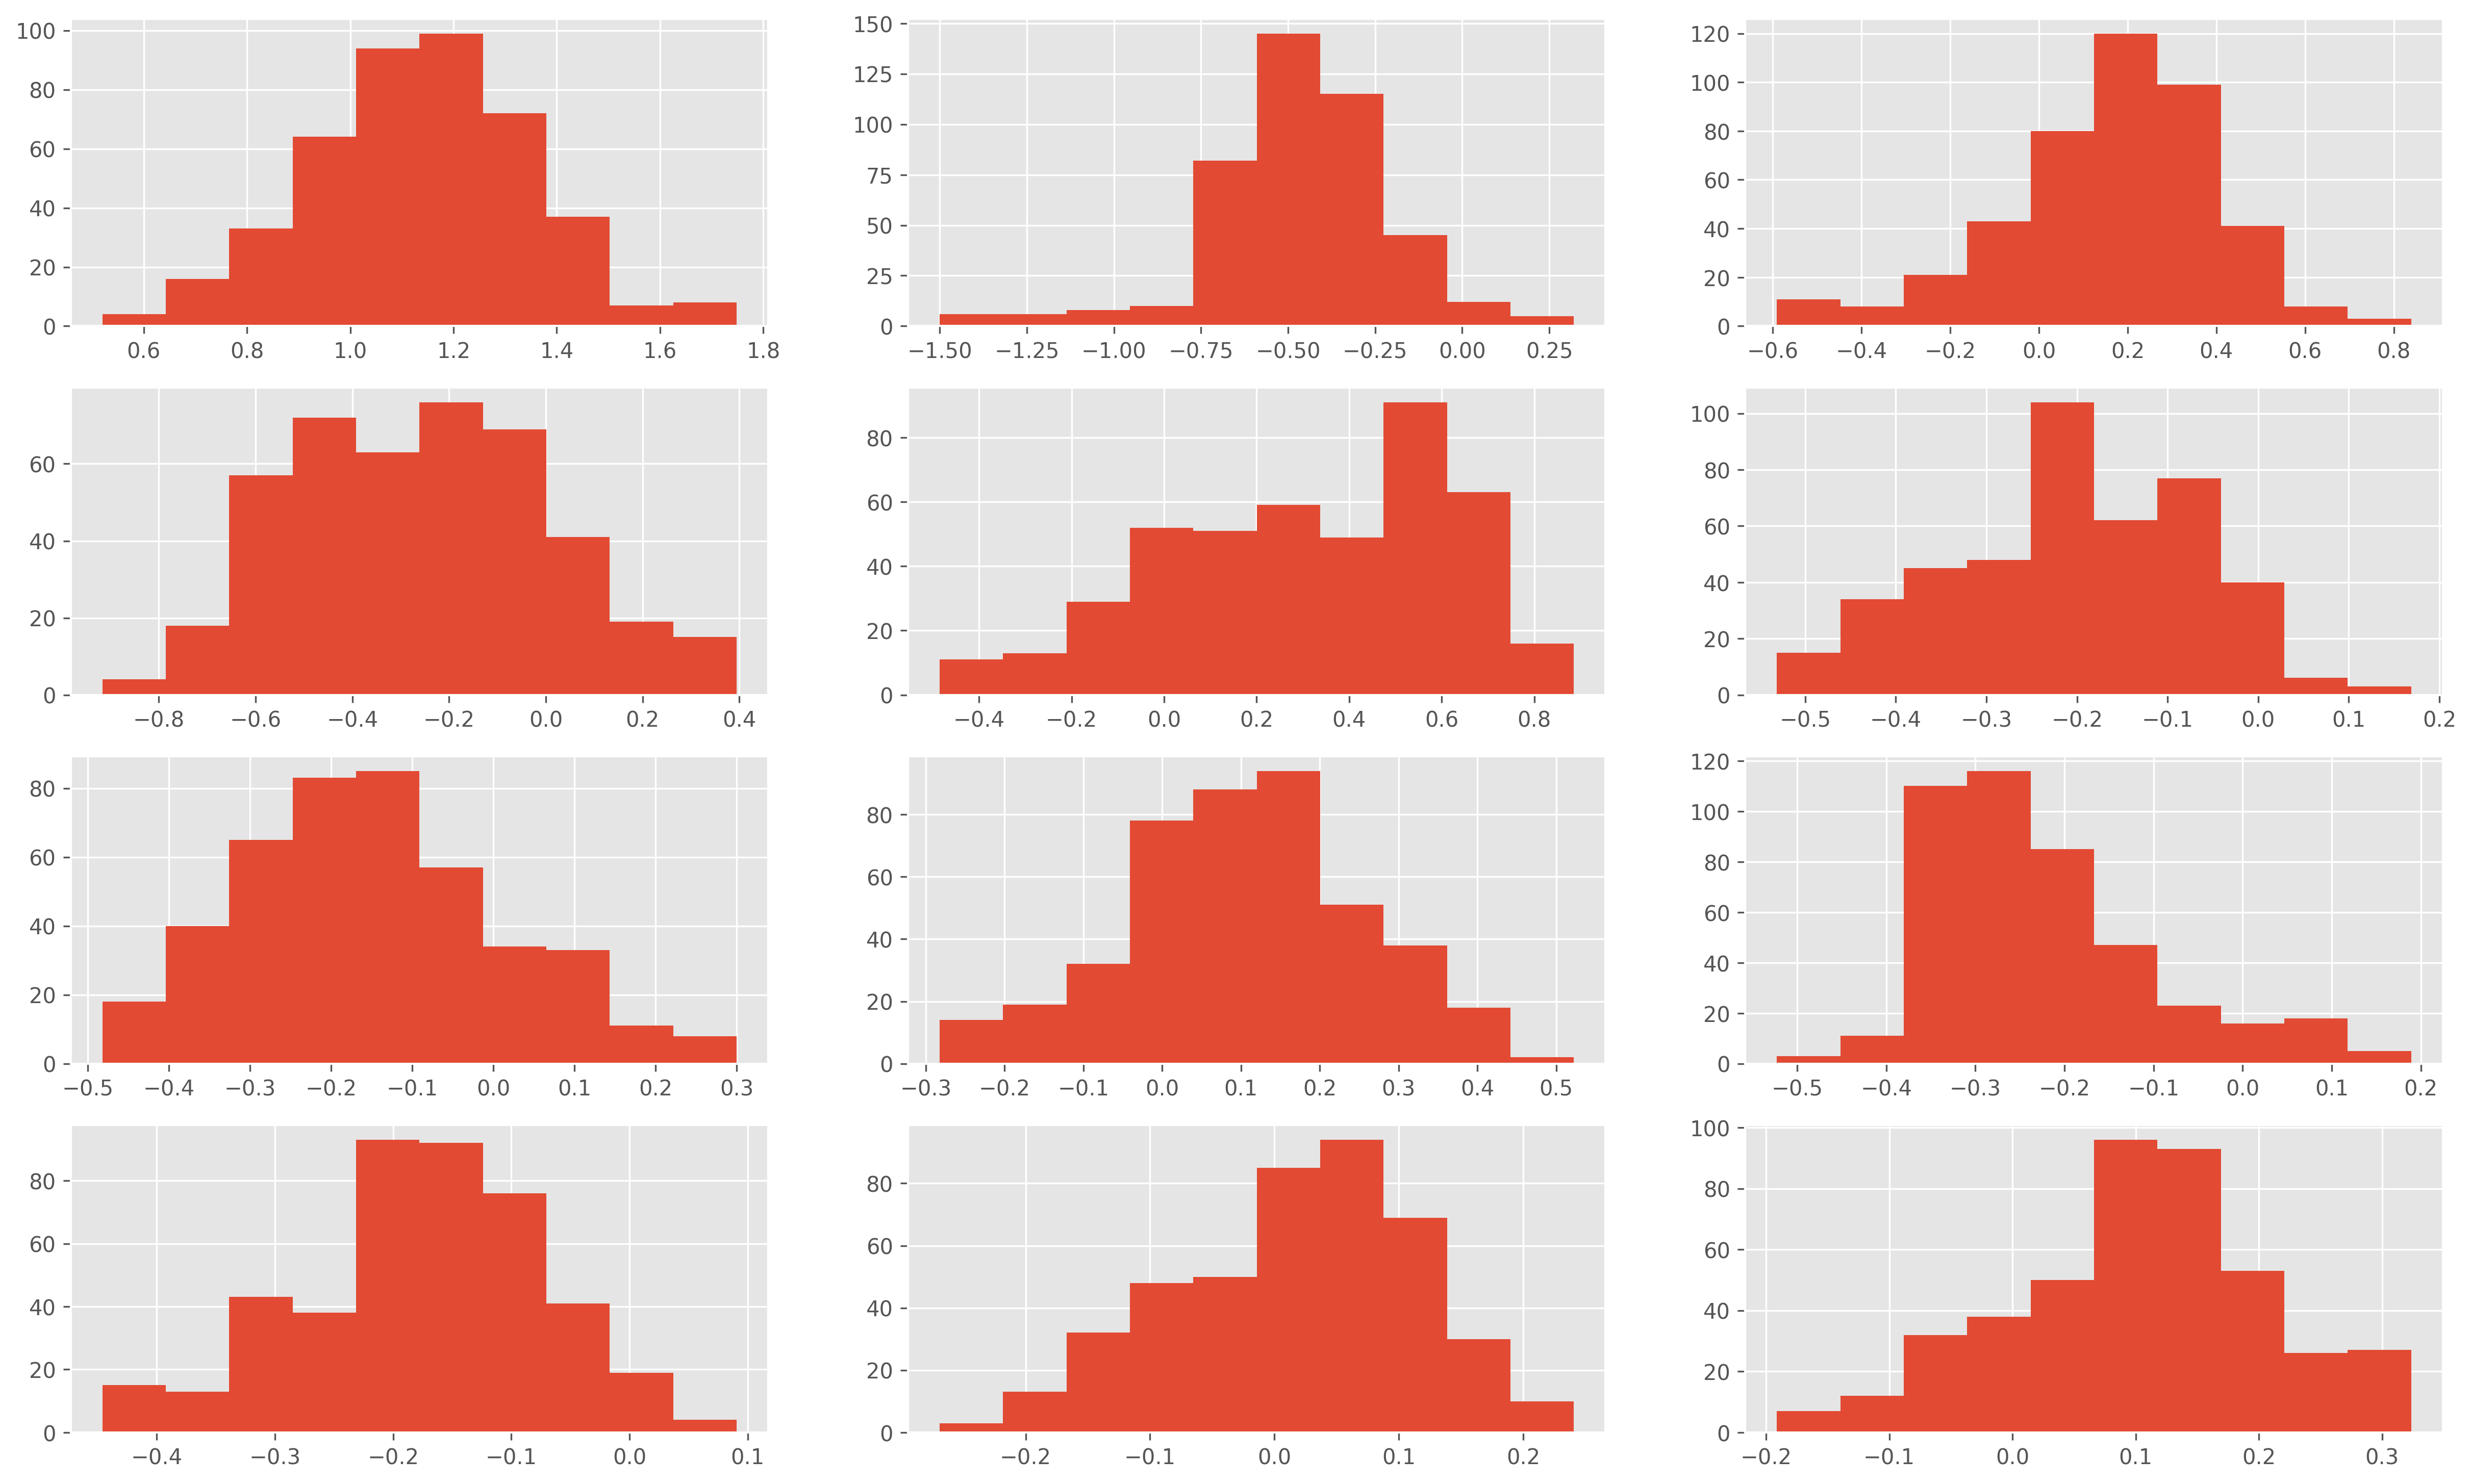

In [19]:
plt.subplots(4, 3, figsize=(20, 12), dpi=300)
datas = [[] for _ in range(12)]
for x in range(4):
    for y in range(3):
        for i in range(30):
            datas[x*3+y] += list(tests[269-i][x*3+y].values)
            
for x in range(4):
    for y in range(3):
        plt.subplot(4, 3, 3 * x + 1 + y)
        plt.hist(datas[3*x+y])

In [20]:
### visualize the first person's histgram

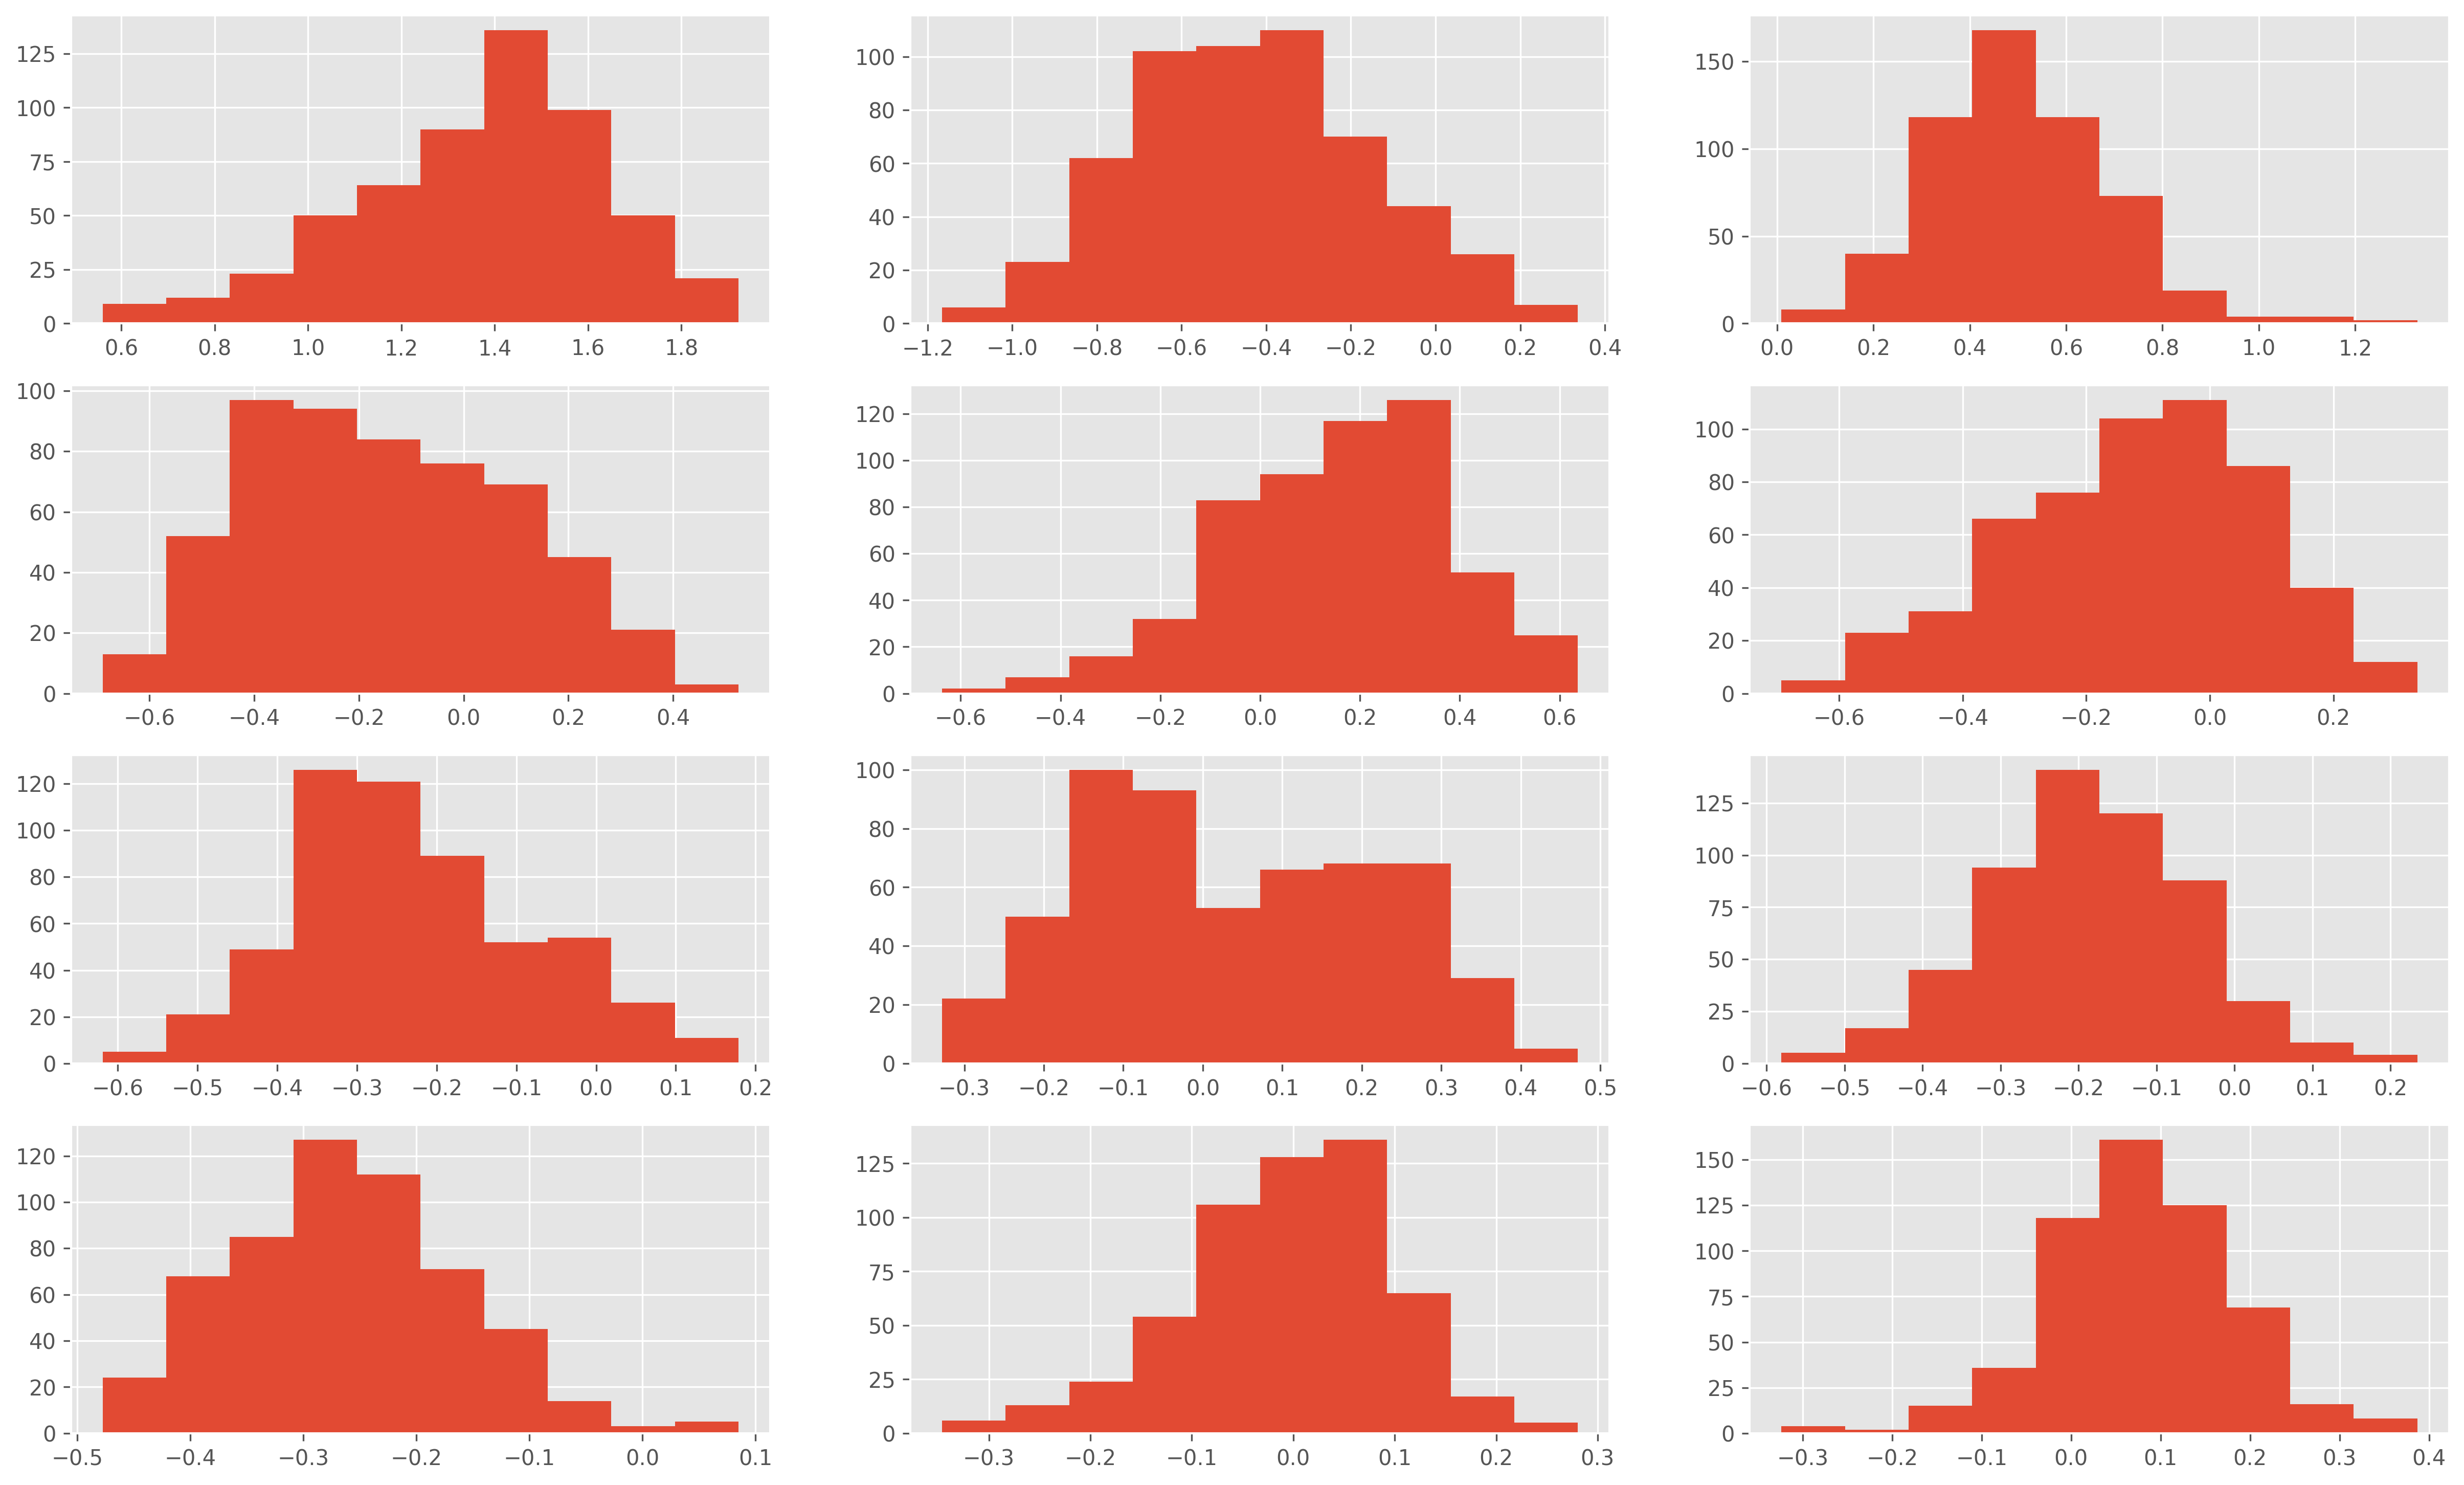

In [21]:
plt.subplots(4, 3, figsize=(20, 12), dpi=300)
datas = [[] for _ in range(12)]
for x in range(4):
    for y in range(3):
        for i in range(labels[0]):
            datas[x*3+y] += list(trains[i][x*3+y].values)
            
for x in range(4):
    for y in range(3):
        plt.subplot(4, 3, 3 * x + 1 + y)
        plt.hist(datas[3*x+y])

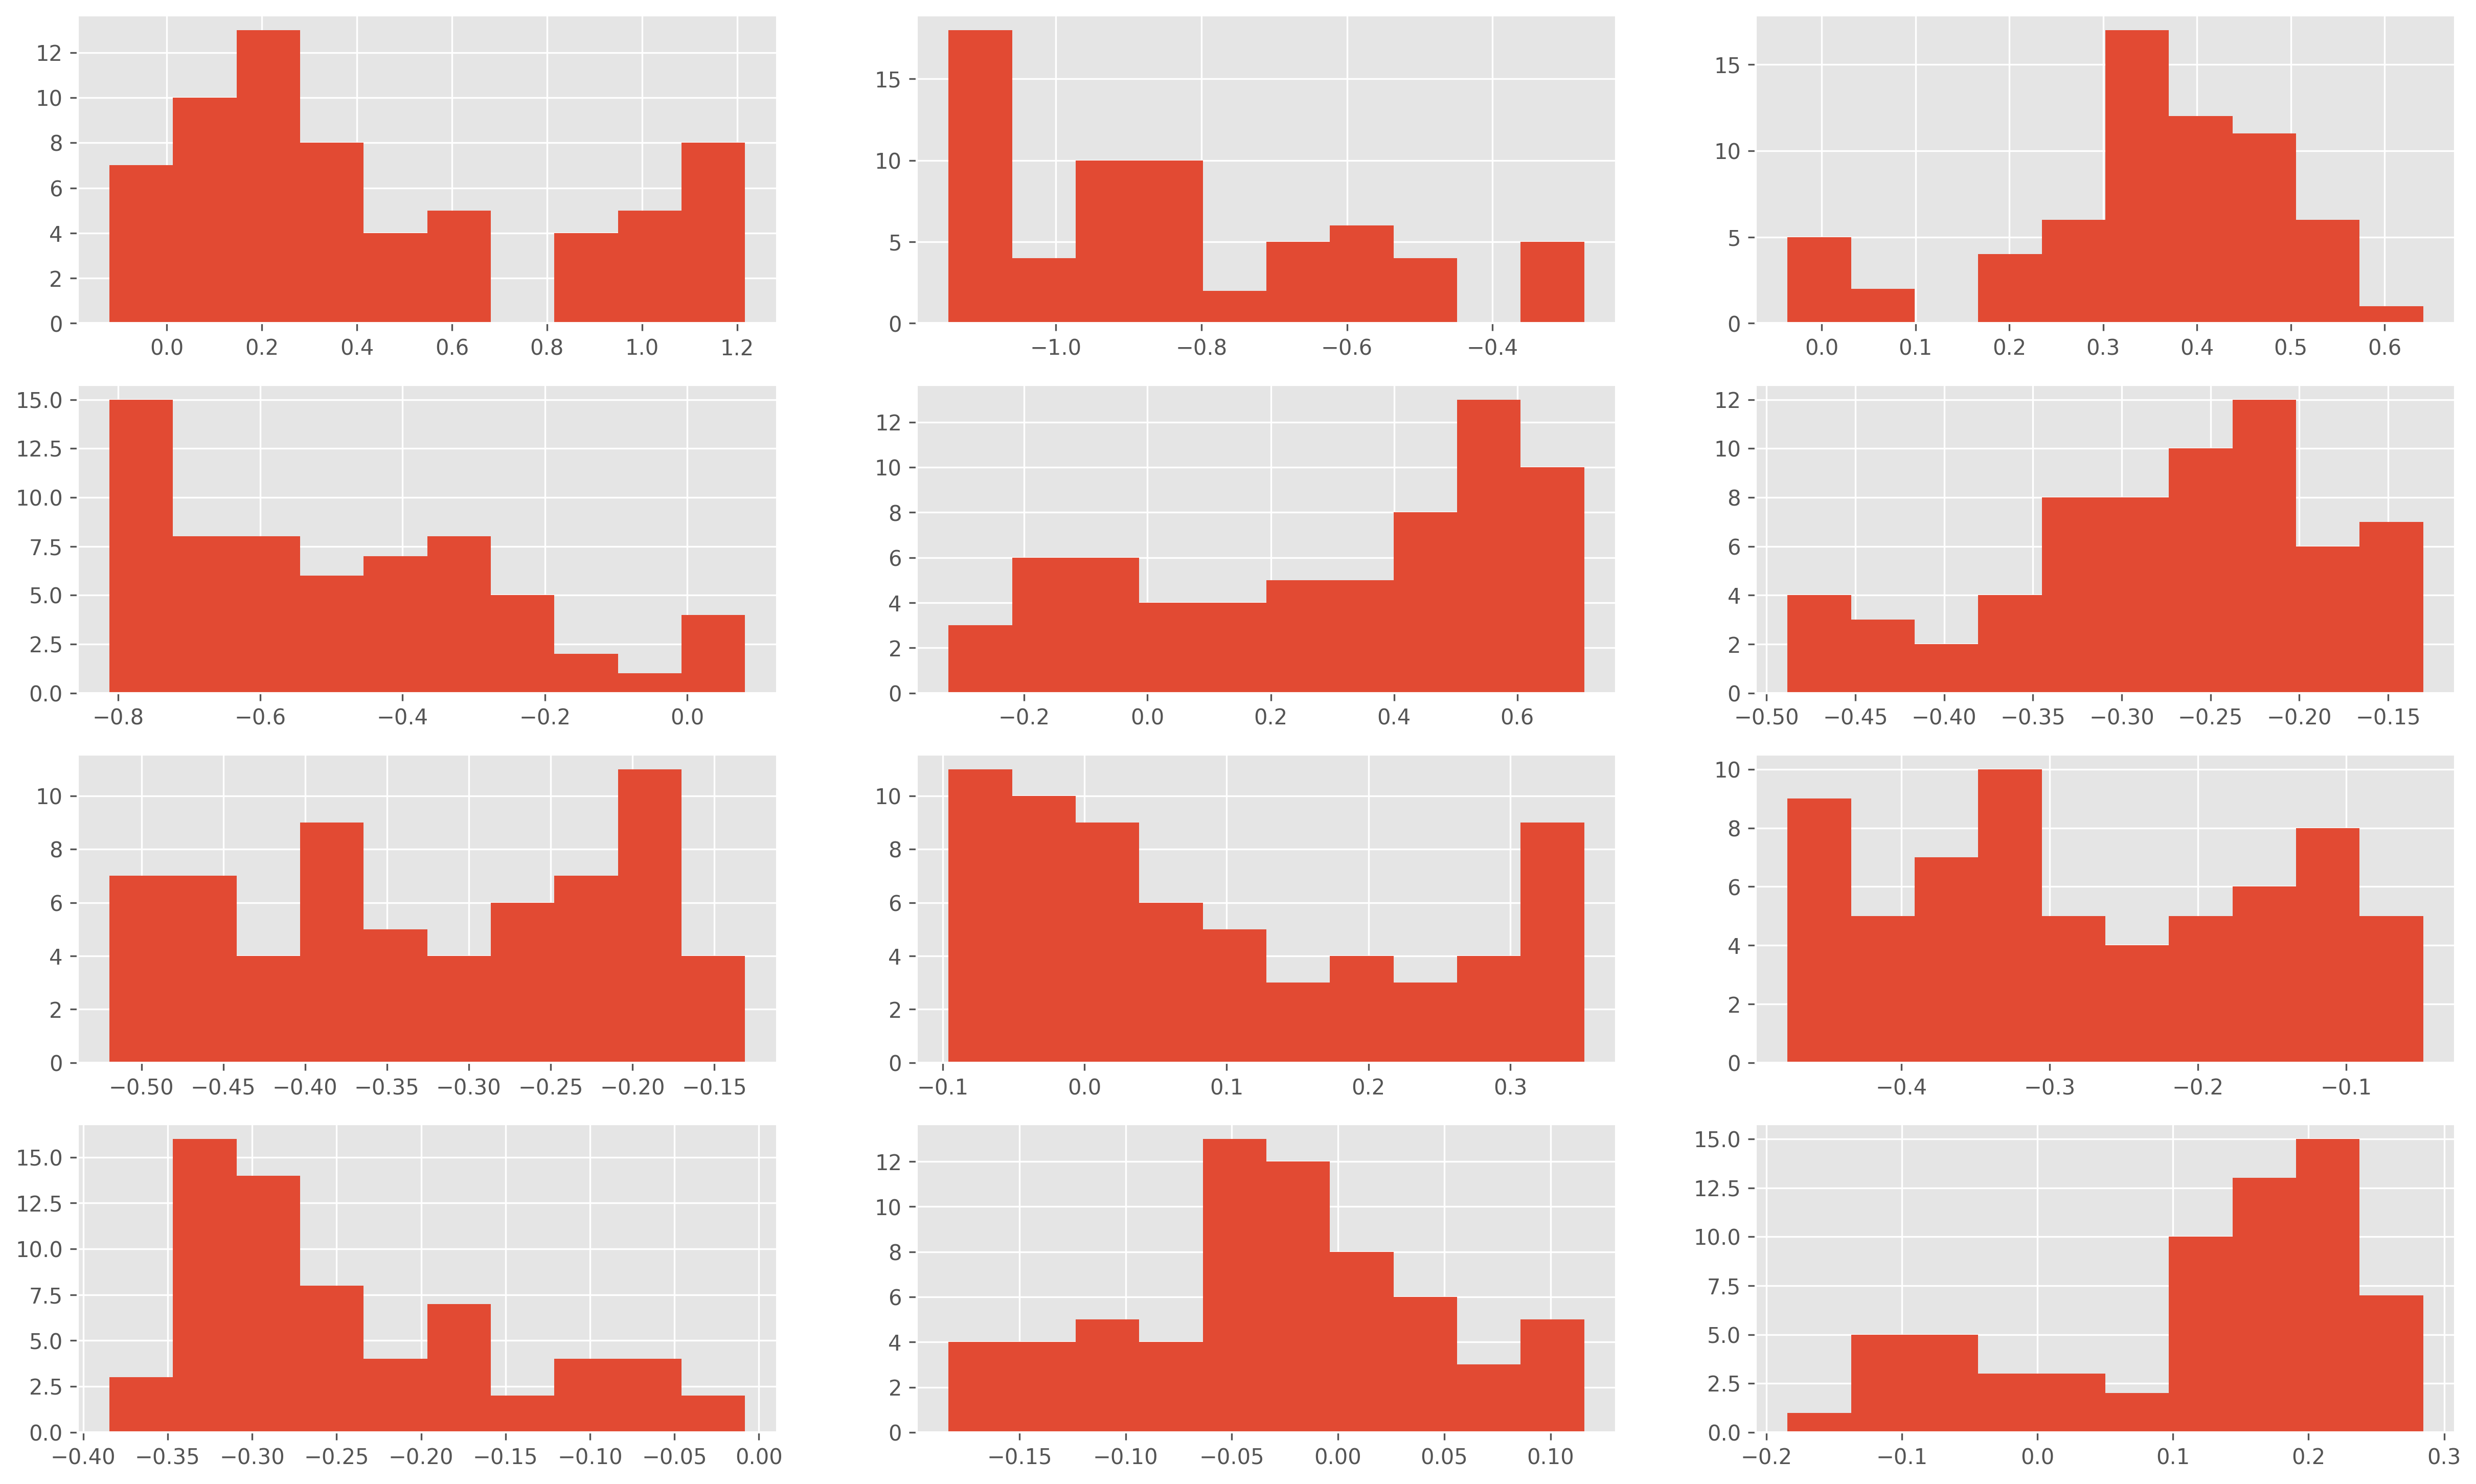

In [22]:
plt.subplots(4, 3, figsize=(20, 12), dpi=300)
# plt.suptitle('12 channels histogram', size = 24)
datas = [[] for _ in range(12)]
for x in range(4):
    for y in range(3):
        for i in range(labels[0], labels[1]):
            datas[x*3+y] += list(trains[i][x*3+y].values)
            
for x in range(4):
    for y in range(3):
        plt.subplot(4, 3, 3 * x + 1 + y)
        plt.hist(datas[3*x+y])

### auto-correlation

<AxesSubplot: >

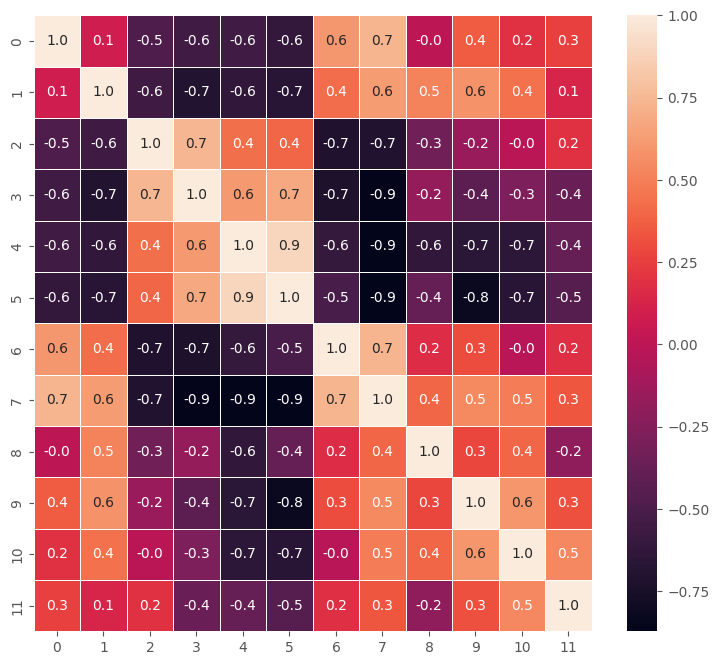

In [23]:
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(trains[0].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# Data Preprocessing

## Make the length of all dataset same - padding

In [24]:
max_length = max(trains[i].shape[0] for i in range(len(trains)))  # 29
# max_length = 24

In [25]:
### if the length is greater than max_length, then cut it. if not, then pad it.

In [26]:
for i in range(len(trains)):
    last_idx = trains[i].shape[0] - 1
    if last_idx < max_length:
        for row in range(last_idx+1, max_length):
            trains[i].loc[row, :] = trains[i].loc[last_idx-1, :]
    else:
        trains[i] = trains[i].drop(index=list(range(max_length-1, last_idx)))

In [27]:
for i in range(len(tests)):
    last_idx = tests[i].shape[0] - 1
    if last_idx < max_length:
        for row in range(last_idx+1, max_length):
            tests[i].loc[row, :] = tests[i].loc[last_idx, :]
    else:
        tests[i] = tests[i].drop(index=list(range(max_length-1, last_idx)))

## Data augmentation

In [28]:
n = len(trains)

In [29]:
def jitter(x, sigma=0.03):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

#### weighted resample 

In [30]:
# get the index range for all training set
labels_index = [0]
for i in range(len(labels)):
    labels_index.append(labels_index[-1] + labels[i])

max_samples = max(labels)

labels_augment = list(labels_long)

# data augmentation
for i in range(9):
    lack_sample = max_samples - labels[i] # requires `lack_sample` new samples
    for number in range(lack_sample):
        idx = random.randint(labels_index[i], labels_index[i+1]-1) # pick corresponding data
        new_train = trains[idx]
        new_train = jitter(new_train, 0.1)
        trains.append(new_train)
        labels_augment.append(i)
labels_long = np.array(labels_augment)


In [31]:
len(labels_long)

792

#### augment all data

In [32]:
augmentations = 2  # make training set `augmentations` size as original
n = len(trains)
labels_augment = list(labels_long)
for _ in range(1, augmentations):
    trains_augment = []
    for i in range(n):
        trains_augment.append(jitter(trains[i], 0.1))
    trains += trains_augment[:]
    labels_augment += list(labels_long)
labels_long = np.array(labels_augment)

In [33]:
len(labels_long)

1584

#### augment last label data

In [34]:
# labels_augment = list(labels_long)

# columns = np.arange(12)
# np.random.shuffle(columns)
# trains_augment = []
# for i in range(sum(labels[:-1]), len(trains)):
#     trains_augment.append(trains[i][columns])
    
# trains += trains_augment[:]

# labels_augment += [8] * labels[-1]

# labels_long = np.array(labels_augment)

## data stacking

In [35]:
# making list of pandas DataFrame into 3-D numpy array
trains = np.stack(trains)
tests = np.stack(tests)

In [36]:
trains.shape

(1584, 29, 12)

In [37]:
tests.shape

(270, 29, 12)

# Model

## LSTM

In [38]:
seq_len, width = trains[0].shape  # get the input shape
labels_LSTM = pd.get_dummies(labels_long).values  # encode the labels

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    trains, labels_LSTM, test_size=0.2, stratify=labels_long , random_state=42)

In [40]:
X_train.shape

(1267, 29, 12)

In [41]:
layer_size = 256
patience = 10
max_epochs = 200

In [42]:
model = Sequential()
model.add(LSTM(layer_size, activation='relu', input_shape=(seq_len, width)))
model.add(Dense(9, activation='softmax'))

2022-11-29 22:24:47.160267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               275456    
                                                                 
 dense (Dense)               (None, 9)                 2313      
                                                                 
Total params: 277,769
Trainable params: 277,769
Non-trainable params: 0
_________________________________________________________________


In [44]:
adam = Adam(learning_rate=0.001)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 10,
                                                  mode = 'min',
                                                  restore_best_weights = True)

model.compile(loss = 'binary_crossentropy',
              optimizer = adam,
              metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = max_epochs,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping])

Epoch 1/200
40/40 [==============================] - 3s 39ms/step - loss: 0.5334 - accuracy: 0.1744 - val_loss: 0.3812 - val_accuracy: 0.1262
Epoch 2/200
40/40 [==============================] - 1s 34ms/step - loss: 0.3356 - accuracy: 0.2707 - val_loss: 0.2808 - val_accuracy: 0.4164
Epoch 3/200
40/40 [==============================] - 1s 36ms/step - loss: 0.2167 - accuracy: 0.5406 - val_loss: 0.2148 - val_accuracy: 0.7319
Epoch 4/200
40/40 [==============================] - 1s 34ms/step - loss: 0.1406 - accuracy: 0.7798 - val_loss: 0.1134 - val_accuracy: 0.8360
Epoch 5/200
40/40 [==============================] - 1s 34ms/step - loss: 0.0883 - accuracy: 0.8698 - val_loss: 0.0679 - val_accuracy: 0.9085
Epoch 6/200
40/40 [==============================] - 1s 34ms/step - loss: 0.0761 - accuracy: 0.8927 - val_loss: 0.0922 - val_accuracy: 0.8391
Epoch 7/200
40/40 [==============================] - 1s 33ms/step - loss: 0.0787 - accuracy: 0.9037 - val_loss: 0.1319 - val_accuracy: 0.7918
Epoch 

In [45]:
## plot the loss curve

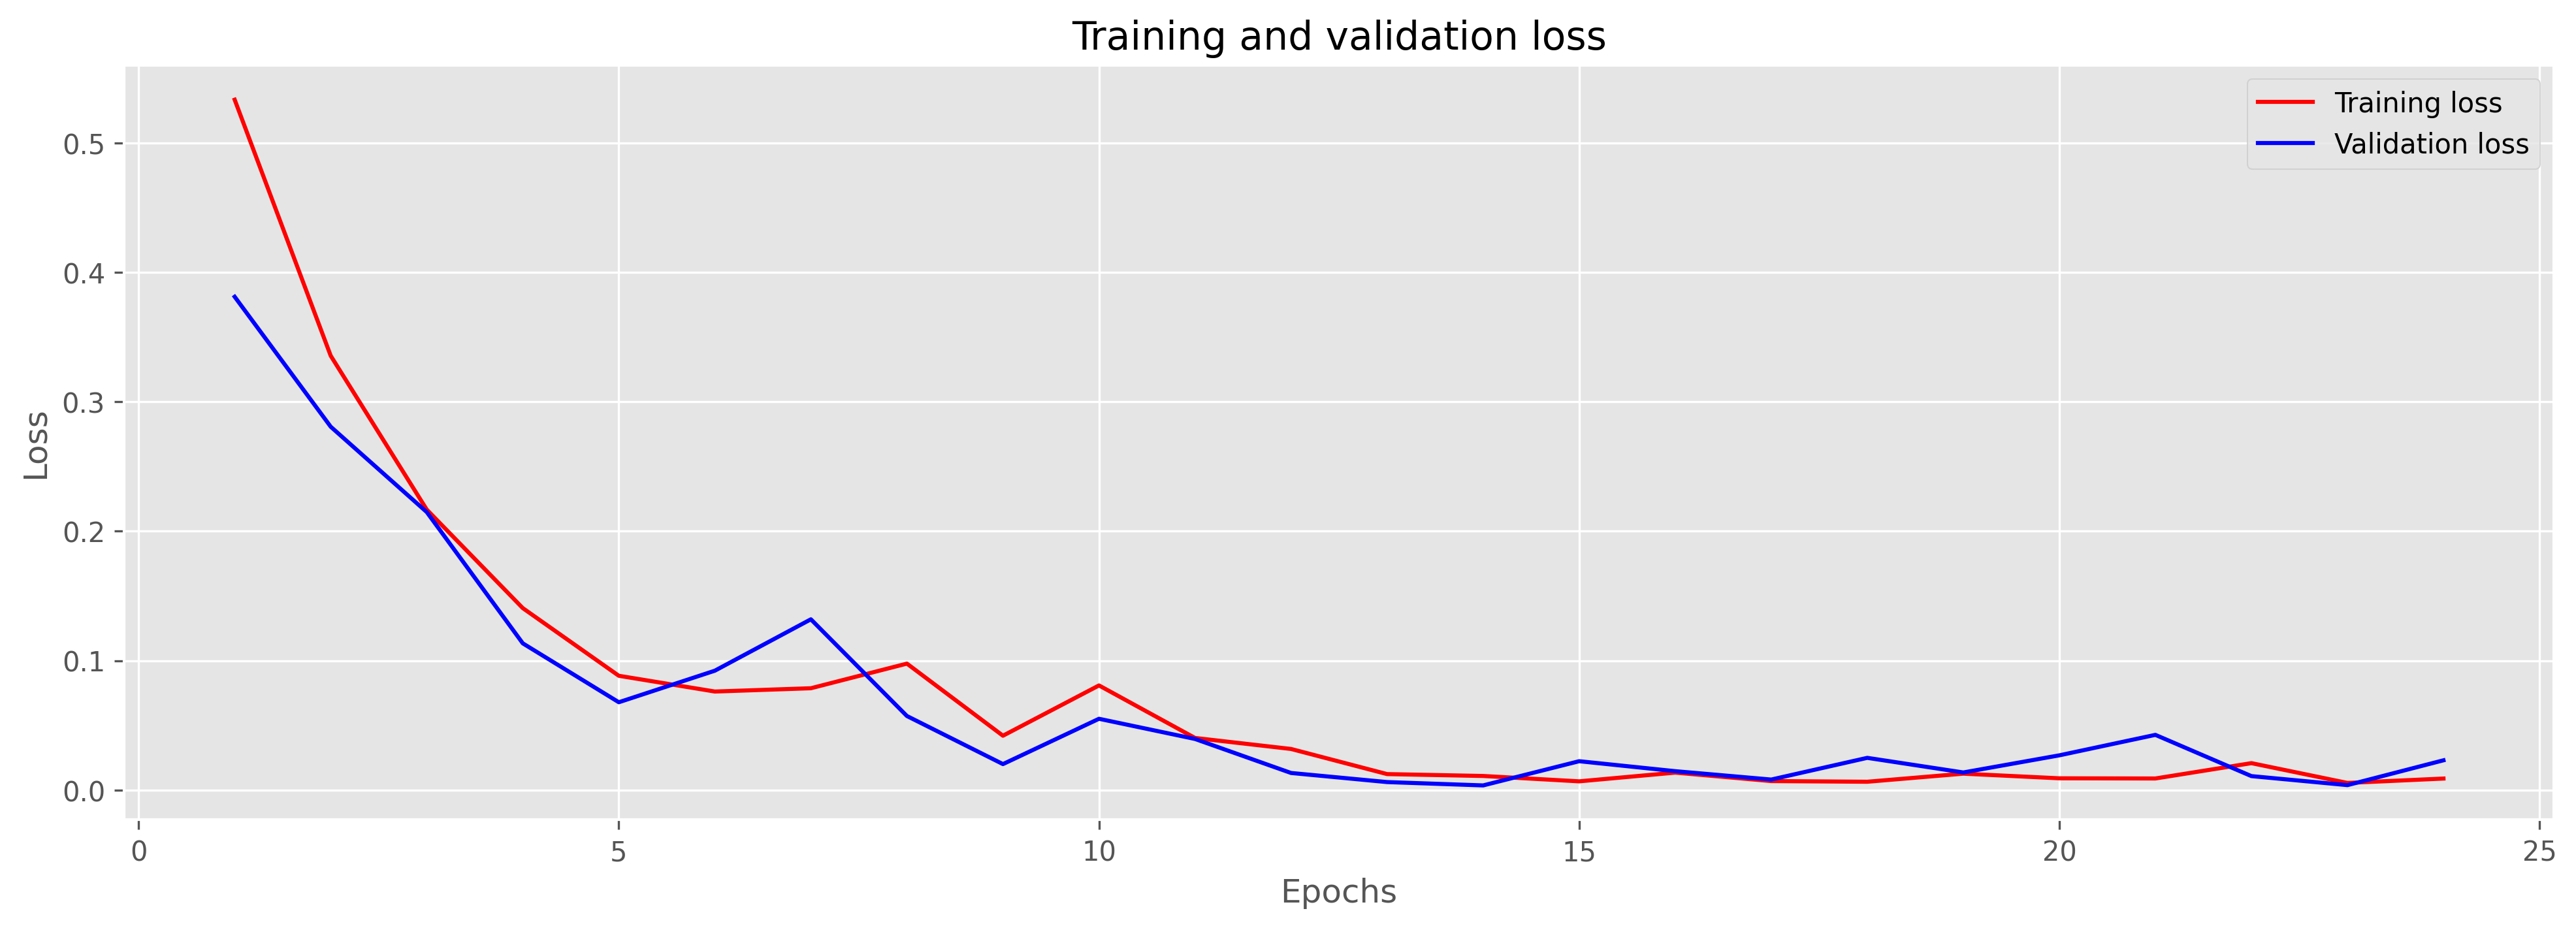

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(16, 5), dpi=300)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [47]:
y_val_pred = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred, axis=1)

10/10 [==============================] - 0s 11ms/step


In [48]:
# recover the label for making confusion matrix
y_val_label = np.argmax(y_val, axis=1)

In [49]:
cm_val = confusion_matrix(y_val_label, y_val_pred)
cm_val

array([[35,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 35,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 34,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 35,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 36,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 35,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 35]])

In [50]:
def worst_user(confusion_matrix):
    # calculate the worst user classification accuracy by confusion matrix
    worst_prediction = 1
    for i in range(len(confusion_matrix)):
        worst_prediction = min(worst_prediction, confusion_matrix[i][i] / sum(confusion_matrix[i]))
    return worst_prediction

In [51]:
y_val_pred = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred, axis=1)

10/10 [==============================] - 0s 11ms/step


In [52]:
print("The classification accuracy is %.4f" % accuracy_score(y_val_label, y_val_pred))
print("The worst performing user accuracy is %.4f" % worst_user(cm_val))

The classification accuracy is 0.9968
The worst performing user accuracy is 0.9714


In [53]:
### predict the test set

In [54]:
y_test_pred = model.predict(tests)
y_test_pred = np.argmax(y_test_pred, axis=1)

9/9 [==============================] - 0s 11ms/step


## sktime

In [55]:
from sktime.classification.hybrid import HIVECOTEV2

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [56]:
hivecote = HIVECOTEV2(time_limit_in_minutes=0.2)

X_train, X_val, y_train, y_val = train_test_split(
    trains, labels_long, test_size=0.2, stratify=labels_long, random_state=42)

hivecote.fit(X_train, y_train)
y_val_pred = hivecote.predict(X_val)

In [57]:
cm_val = confusion_matrix(y_val, y_val_pred)
cm_val

array([[30,  0,  1,  0,  1,  3,  0,  0,  0],
       [ 6, 30,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  1, 28,  0,  0,  2,  0,  0,  0],
       [ 2,  1,  0, 27,  0,  5,  0,  0,  0],
       [ 2,  0,  0,  0, 32,  0,  0,  1,  0],
       [ 2,  0,  0,  0,  0, 32,  0,  0,  1],
       [ 6,  4,  0,  0,  0,  4, 21,  0,  0],
       [ 5,  2,  0,  0,  0,  3,  0, 26,  0],
       [ 5,  0,  0,  0,  1,  1,  0,  0, 28]])

In [58]:
print("The classification accuracy is %.4f" % accuracy_score(y_val, y_val_pred))
print("The worst performing user accuracy is %.4f" % worst_user(cm_val))

The classification accuracy is 0.8013
The worst performing user accuracy is 0.6000


/var/folders/57/47jcsk4j1j11kgyfzkdh89zh0000gn/T/ipykernel_31656/3008501508.py:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


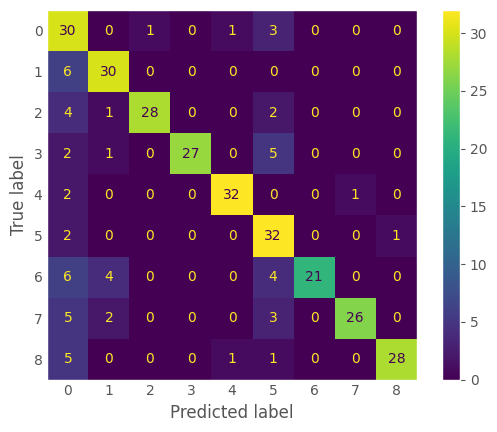

In [59]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=hivecote.classes_)
disp.plot()
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.grid(b=None)
plt.show()

In [60]:
### predict the test set

In [61]:
y_test_pred = hivecote.predict(tests)

# Make Prediction

In [127]:
result = pd.read_csv('sample_submission.csv')

In [128]:
result['prediction'] = y_test_pred

In [129]:
result.to_csv('final_submission.csv', index=False)